In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy
import statsmodels.stats.multitest as smm
%matplotlib inline

In [2]:
frame = pd.read_csv("gene_high_throughput_sequencing.csv", index_col=False) 
frame.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


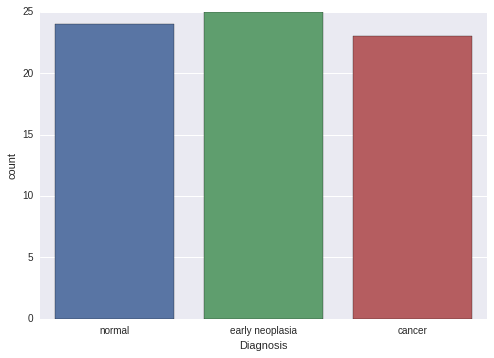

In [3]:
sns.set(style='darkgrid')
ax = sns.countplot(x='Diagnosis',data=frame)

In [4]:
def f(x,y):
    return scipy.stats.ttest_ind(x, y, equal_var = False)

In [5]:
frame1 = frame.ix[[1,2]]

In [6]:
cancer = frame[frame.Diagnosis == "cancer"]
normal = frame[frame.Diagnosis == "normal"]
early_neoplasia = frame[frame.Diagnosis == "early neoplasia"]

In [7]:
genes=list(frame.columns.values)
genes.remove('Patient_id')
genes.remove('Diagnosis')

In [8]:
res1=map(f,normal[genes].values.T,early_neoplasia[genes].values.T)
res2=map(f,cancer[genes].values.T,early_neoplasia[genes].values.T)

In [9]:
p_val1=[i.pvalue for i in res1]
p_val2=[i.pvalue for i in res2]

In [10]:
filt = lambda x: 1 if x<0.05 else 0
res1 = sum(filt(i) for i in p_val1)
res2 = sum(filt(i) for i in p_val2)

In [11]:
print res1, res2

1575 3490


In [12]:
with open("1.1","w") as f:
    f.write(str(res1))
with open("1.2","w") as f:
    f.write(str(res2))

### Часть 2: поправка методом Холма

Для этой части задания вам понадобится модуль multitest из statsmodels.

`import statsmodels.stats.multitest as smm`

В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 1.5.

**Обратите внимание, что**

применять поправку на множественную проверку нужно ко всем значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия.
при использовании поправки на уровне значимости 0.025 меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом 0.025, а не 0.05)!


In [25]:
reject, p_corrected, a1, a2 = smm.multipletests(p_val1, 
                                            alpha = 0.025, 
                                            method = 'holm') 

In [26]:
t_ind = pd.Series(reject)
t_ind  = t_ind[t_ind==True]

In [27]:
index = t_ind.index.values

In [28]:
T=normal.ix[:,index+2].mean()
C=early_neoplasia.ix[:,index+2].mean()

In [29]:
def F(C,T):
    if C>T:
        return C/T
    else:
        return T/C

In [30]:
F_values = pd.Series(map(F,C,T))

In [31]:
res = F_values[F_values>1.5].count()

In [32]:
res

2

In [ ]:
with open("2.1","w") as f:
    f.write(str(res))

In [36]:
reject, p_corrected, a1, a2 = smm.multipletests(p_val2, 
                                            alpha = 0.025, 
                                            method = 'holm')

In [37]:
t_ind = pd.Series(reject)
t_ind  = t_ind[t_ind==True]
t_ind.index
index = t_ind.index.values
T=cancer.ix[:,index+2].mean()
C=early_neoplasia.ix[:,index+2].mean()
F_values = pd.Series(map(F,C,T))

In [38]:
res = F_values[F_values>1.5].count()

In [39]:
res

77

In [ ]:
with open("2.2","w") as f:
    f.write(str(res))

### Часть 3: поправка методом Бенджамини-Хохберга

In [57]:
reject, p_corrected, a1, a2 = smm.multipletests(p_val1, 
                                            alpha = 0.025, 
                                            method = 'fdr_i') 

In [46]:
t_ind = pd.Series(reject)

In [47]:
t_ind.value_counts()

False    15744
True         4
dtype: int64

In [77]:
t_ind = pd.Series(reject)
t_ind  = t_ind[t_ind==True]
t_ind.index
index = t_ind.index.values
T=normal.ix[:,index+2].mean()
C=early_neoplasia.ix[:,index+2].mean()
F_values = pd.Series(map(F,C,T))
res = F_values[F_values>=1.5].count()
with open("3.1","w") as f:
    f.write(str(res))

In [78]:
res

34

In [ ]:
F_values

In [69]:
reject, p_corrected, a1, a2 = smm.multipletests(p_val2, 
                                            alpha = 0.025, 
                                            method = 'fdr_bh')

In [80]:
t_ind = pd.Series(reject)
t_ind  = t_ind[t_ind==True]
index = t_ind.index.values
T=cancer.ix[:,index+2].mean()
C=early_neoplasia.ix[:,index+2].mean()
F_values = pd.Series(map(F,C,T))
res = F_values[F_values>1.5].count()
with open("3.2","w") as f:
    f.write(str(res))

In [81]:
res

524